Practice learning transfer

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
torchvision.__version__

'0.22.1'

In [3]:
from utils import data_setup, engine


/Users/mikeqin/code/ml_learning/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

### get data

In [6]:
# get data
import os
import zipfile
from pathlib import Path

import requests

data_path = Path("data/")

image_path = data_path #/ "pizza_steak_sushi"

if image_path.is_dir():
    print(f"image path exist")
else: 
    print("did not find file. downloading...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_streak_sushi.zip", "wb") as f:
        request = requests.get()
        print("downloading...")
        f.write(request.content)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

    os.remove(data_path/"pizza_stream_sushi.zip")

image path exist


In [7]:
# set directory path


train_dir = Path('data/pizza_steak_sushi/train')
test_dir = Path('data/pizza_steak_sushi/test')
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

create datasets and dataloaders using `data_setup.py` and `create_dataloader.py` 

In [8]:
# one of the two ways:
# 1. manually create transforms - you define the transforms you want your data to go through
# 2. automatically create transforms _ the transforms for your data are defined by the model you'd like to use (req torchvision 1.13+)

# important: when usiing a pretrained model, the data, including your custom data, that you pass through it is **transformed** in the same waythat the model was trained on


In [9]:
# method 1: manually create a transform
# https://docs.pytorch.org/vision/stable/models.html#initializing-pre-trained-models
# https://docs.pytorch.org/vision/stable/transforms.html#start-here

from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])



In [11]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32)

In [12]:
# method 2: automatically create a data transform for torchvision.models
# https://docs.pytorch.org/vision/stable/models.html#initializing-pre-trained-models

# get a set of pretrained model weights

# https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # <-- best available
weights


EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x12fc86cf0>,
 ['pizza', 'steak', 'sushi'])

### getting a pretrained model
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub
4. Paperswithcode(for models across different problem spaces/domains)

which pretrained model should you use? A million dollor questions: *Experiment, Experiment, Experiment!*

3 things to consider: 
1. speed (how fast does it run?)
2. size (how big is the model? # of parameters and size on disk)
3. performance (how well does it go on your problem?)

Generally smaller size runs faster, although not always true. https://docs.pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

where does the model live?  Is it on device (like a self-driving car) or on a server?

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most paramters + most general method we could

In [15]:
# will use this pretrained model: https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights


In [16]:
# old way
model = torchvision.models.efficientnet_b0(pretrained=True)

/Users/mikeqin/code/ml_learning/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mikeqin/code/ml_learning/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# new method:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

### EfficientNet feature extractor
See 06_pytorch_tranfer_learning_ipynb


### kinds of transfer learning
1. Feature Extraction
2. Fine-Tuning


In [19]:
# getting a summary of our pretrained model using torchinfo.summary
summary(model=model,
    input_size=(1,3,224,224), # example of (batch_size, color_channels, height, width)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [20]:
# freeze the base model and change the output layer to suit our needs - this is normally a feature extractor model do.
# for param in model.features.parameters():
#     print(param)

for param in model.features.parameters():
    param.requires_grad = False


In [21]:
# note the trainable column changes:
summary(model=model,
    input_size=(1,3,224,224), # example of (batch_size, color_channels, height, width)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [22]:
# update the classifier head of our model to suite our problem
# head: means the layers close to the outputs
torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,
               inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names)).to(device)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [23]:
summary(model=model,
    input_size=(1,3,224,224), # example of (batch_size, color_channels, height, width)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [24]:
# train model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
from utils import engine

torch.manual_seed(42)

from timeit import default_timer as timer

start = timer()

result = engine.train(model=model,
                     train_dataloader=train_dataloader, 
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn, 
                     optimizer=optimizer,
                     epochs=5,
                     device=device)

end = timer()
print(f"total training time: {end-start:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]/Users/mikeqin/code/ml_learning/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 20%|██        | 1/5 [01:05<04:23, 65.77s/it]

Epoch: 1 | train_loss: 1.0815 | train_acc: 0.4023 | test_loss: 0.8985 | test_acc: 0.5909


 40%|████      | 2/5 [02:06<03:07, 62.62s/it]

Epoch: 2 | train_loss: 0.8574 | train_acc: 0.7734 | test_loss: 0.7932 | test_acc: 0.8456


 60%|██████    | 3/5 [03:05<02:02, 61.20s/it]

Epoch: 3 | train_loss: 0.7885 | train_acc: 0.7930 | test_loss: 0.7392 | test_acc: 0.8561


 80%|████████  | 4/5 [04:05<01:00, 60.56s/it]

Epoch: 4 | train_loss: 0.7205 | train_acc: 0.7500 | test_loss: 0.6350 | test_acc: 0.8655


100%|██████████| 5/5 [05:04<00:00, 61.00s/it]

Epoch: 5 | train_loss: 0.6385 | train_acc: 0.7812 | test_loss: 0.6205 | test_acc: 0.8665
total training time: 305.072 seconds


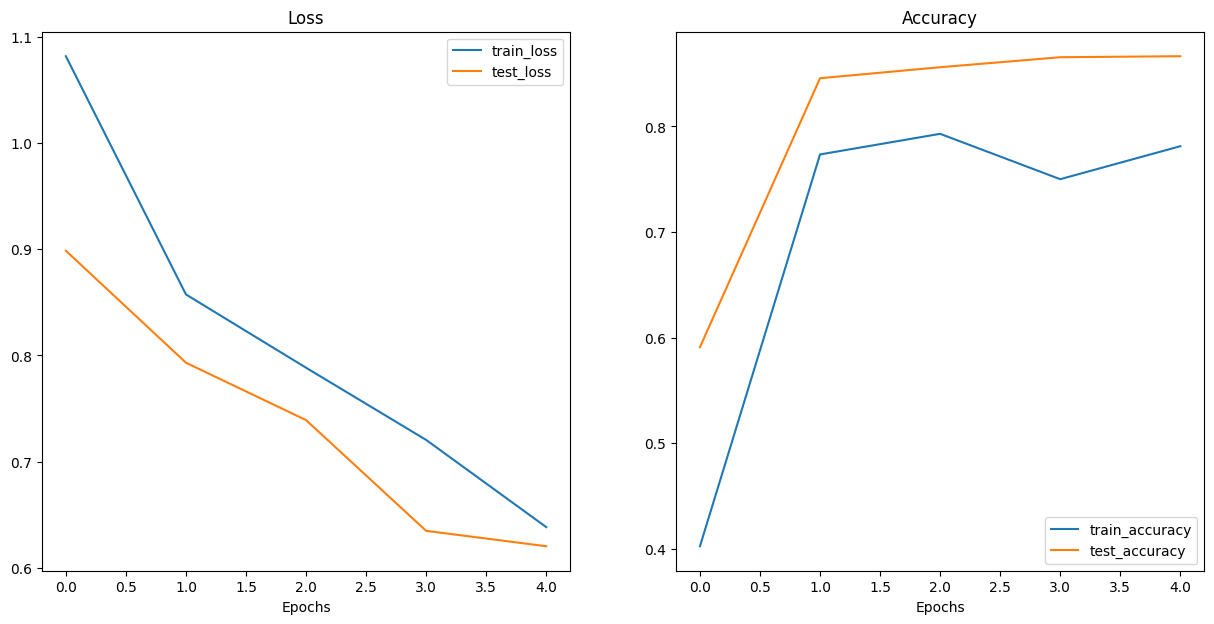

In [26]:
from utils.helper_functions import plot_loss_curves
# Plot the loss curves of our model
plot_loss_curves(result)

In [28]:
from PIL import Image

from torchvision import transforms

# take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str],
                        image_size: tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

  img = Image.open(image_path)

  # create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])
  
  # turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device)) 
  
  # convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # plot image with predicted label and probability
  plt.figure()
  plt.imshow(img) 
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

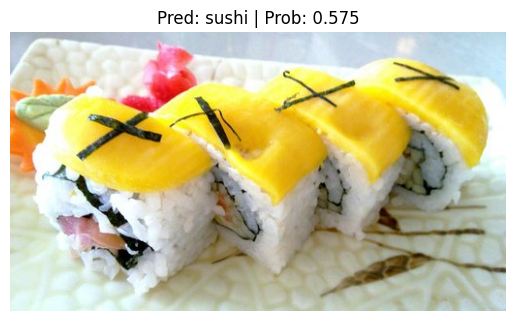

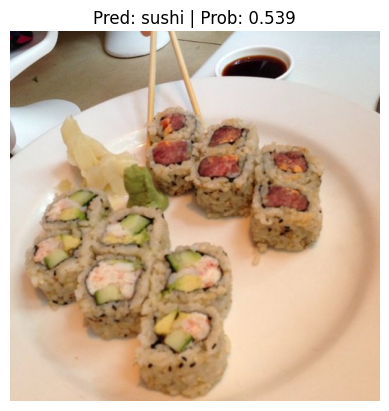

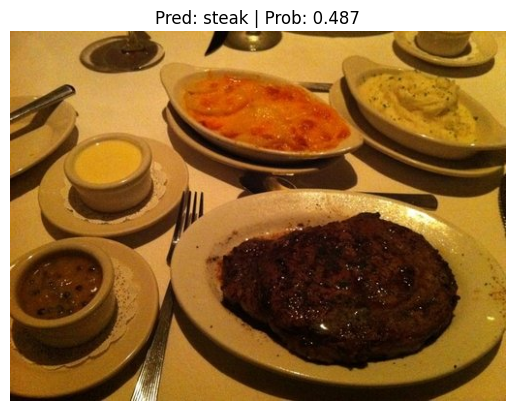

In [29]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))